In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from __future__ import division

In [70]:
data_downsampled = np.genfromtxt('data_sanders_downsampled.csv', delimiter=',')

In [71]:
data_downsampled.shape

(627, 3)

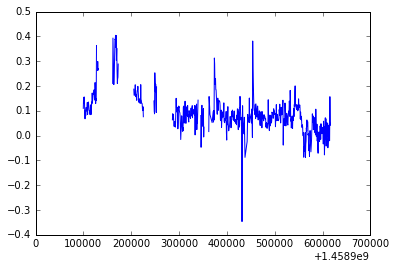

In [72]:
plt.plot(data_downsampled[:,0], data_downsampled[:,1])

In [73]:
%%capture
data = np.genfromtxt('data_sanders_00000.csv', delimiter=',', usecols=(0,1,2), invalid_raise=False, loose=True);

In [74]:
data.shape

(106425, 3)

In [75]:
data[0]

array([  1.45945647e+09,   0.00000000e+00,   7.04857973e+17])

In [76]:
data = np.array([d for d in data if not d[1] == 0])
print data.shape                 

(69564, 3)


# Mode

In [9]:
from scipy.stats import mode

In [77]:
modes = []
tweetids = []
tweets = 0
min_tweets = 100
prev_time = data[0,0]
R = 10*60

for row in data:
    tweets += 1
    if not row[1] == 0:
        tweetids.append(row[2])
    time_diff = float(row[0]) - prev_time
    if time_diff > R:
        if int(time_diff / R) > 1:
            modes.append([row[0]-(time_diff*0.5), None, None, None])
        elif time_diff > R and tweets > min_tweets:
            m = mode(tweetids)
            modes.append([row[0]-(R*0.5), m[0][0], m[1][0], m[1][0]/len(tweetids), len(tweetids)])
        tweetids = []
        prev_time = float(row[0])
        tweets = 0

In [78]:
np.array(modes).shape

(100, 5)

In [79]:
modes = np.array(modes)

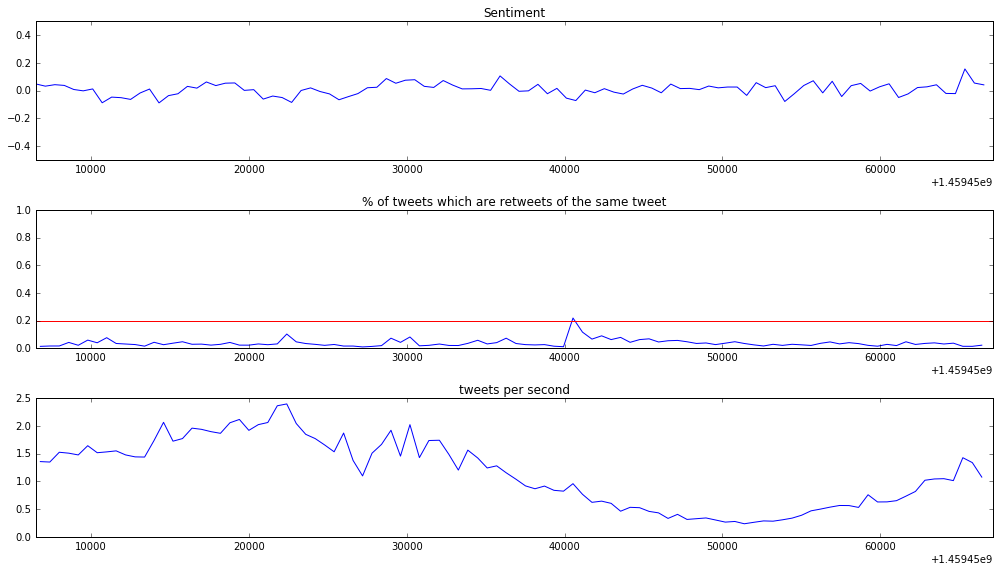

In [80]:
# threshold = np.nanstd(modes[:,3]) * 3
threshold = 0.2

plt.figure(figsize=(14,8))
plt.subplot(311)
plt.title('Sentiment')
plt.plot(data_downsampled[:,0], data_downsampled[:,1])
plt.ylim([-0.5, 0.5])
plt.xlim([data[0,0], data[-1,0]])
plt.subplot(312)
plt.title('% of tweets which are retweets of the same tweet')
plt.plot(modes[:,0], modes[:,3])
plt.ylim([0,1])
plt.xlim([data[0,0], data[-1,0]])
plt.axhline(y=threshold, c='r')
plt.subplot(313)
plt.title('tweets per second')
plt.plot(modes[:,0], modes[:,4]/10/60)
plt.xlim([data[0,0], data[-1,0]])

plt.tight_layout()
plt.show()

In [81]:
a = [m for m in modes if m[3] > threshold]
for x in a:
    for y in x:
        print '{:f}'.format(y)
    print

1459490532.691965
688509515042455552.000000
126.000000
0.219130
575.000000



In [64]:
b = [d[2] for d in data if d[1] == a]

In [65]:
len(b)

0

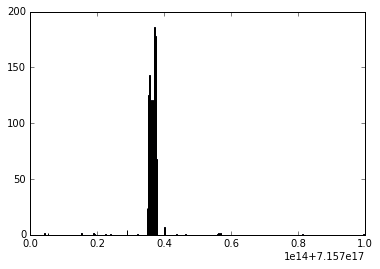

In [55]:
plt.hist(b, 10000)
plt.xlim([7.157e17, 7.158e17])
plt.show()

In [54]:
mode(b)

ModeResult(mode=array([  7.15739932e+17]), count=array([7]))

In [47]:
c = mode(b)[0][0]

In [48]:
print '{:f}'.format(c)

715739932384436224.000000
